In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from src import camvid
from src import tiramisu
from src.utils import heatmap
%matplotlib inline
plt.style.use('dark_background')

Using TensorFlow backend.


In [2]:
!mkdir -p models
# the location to save fine training weights to
weights = './models/Tiramisu103-CamVid11-fine.h5'

In [3]:
mapping = pd.read_table('11_class.txt', sep=r'\s+', names=['og', 'new'], index_col='og')['new'].to_dict()
mapping

{'Animal': 'Pedestrian',
 'Archway': 'Void',
 'Bicyclist': 'Bicyclist',
 'Bridge': 'Void',
 'Building': 'Building',
 'Car': 'Car',
 'CartLuggagePram': 'Void',
 'Child': 'Pedestrian',
 'Column_Pole': 'Column_Pole',
 'Fence': 'Fence',
 'LaneMkgsDriv': 'Road',
 'LaneMkgsNonDriv': 'Road',
 'Misc_Text': 'SignSymbol',
 'MotorcycleScooter': 'Car',
 'OtherMoving': 'Car',
 'ParkingBlock': 'Sidewalk',
 'Pedestrian': 'Pedestrian',
 'Road': 'Road',
 'RoadShoulder': 'Road',
 'SUVPickupTruck': 'Car',
 'Sidewalk': 'Sidewalk',
 'SignSymbol': 'SignSymbol',
 'Sky': 'Sky',
 'TrafficCone': 'Void',
 'TrafficLight': 'Void',
 'Train': 'Car',
 'Tree': 'VegetationMisc',
 'Truck_Bus': 'Car',
 'Tunnel': 'Void',
 'VegetationMisc': 'VegetationMisc',
 'Void': 'Void',
 'Wall': 'Building'}

In [4]:
# the size to reshape images to before transformation
target_size = (360, 480)
# the size to crop images to for fine tune training
crop_size = (352, 480)

In [5]:
# all crop dimensions must be divisible by this value due 
# to the requirement of equal shapes between downsampling 
# outputs and upsampling inputs imposed by the concatenation
# in skip link connections
divisible_by = int(2**5)
# iterate over all the crop dimensions
for dim in crop_size:
    # raise error if the dimension has a remainder when divided
    if dim % divisible_by:
        f = 'crop dimension ({}) must be divisible by {}'
        f = f.format(dim, divisible_by)
        raise ValueError(f)

In [6]:
camvid11 = camvid.CamVid(
    mapping=mapping,
    target_size=target_size,
    crop_size=crop_size,
    horizontal_flip=True,
    ignored_labels=['Void'],
)
generators = camvid11.generators()

Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 233 images belonging to 1 classes.
Found 233 images belonging to 1 classes.


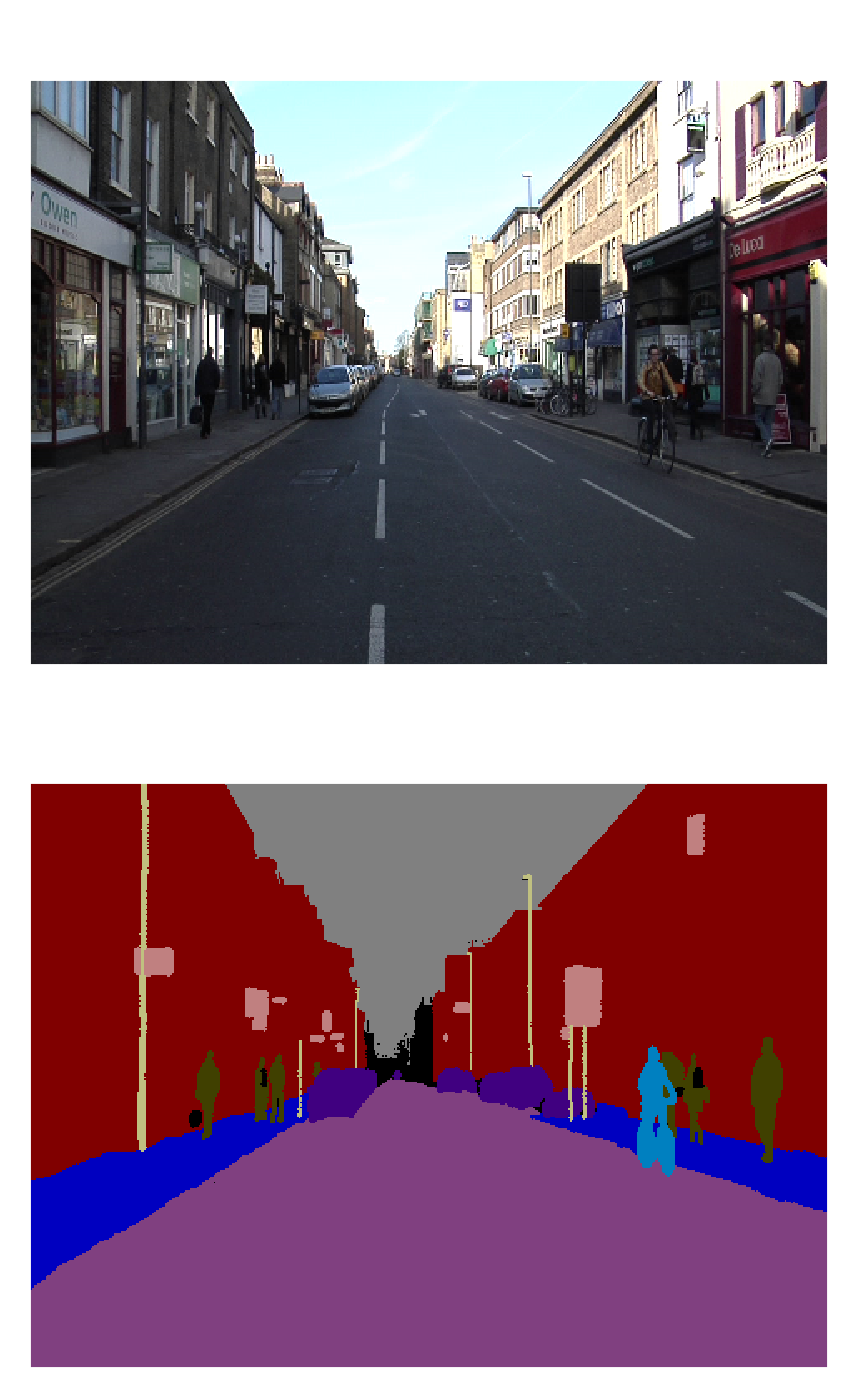

In [7]:
# get the next X, y training tuple
X, y = next(generators['train'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
camvid.plot(X=X[0], y=y[0], order=['X', 'y'])

In [8]:
# build the model for the image shape and number of labels
model = tiramisu.build_epi_approx_tiramisu((*crop_size, 3), camvid11.n,
    label_names=camvid11.discrete_to_label_map,
    class_weights=camvid11.class_mask,
    learning_rate=1e-3,
)
model.summary()

/home/bitcommander/Documents/Projects/neural-semantic-segmentation/src/tiramisu.py:396: UserWarning: Output "entropy" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "entropy" during training.
  'tiramisu': metrics_for_segmentation(num_classes, label_names, class_weights)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 352, 480, 3)       0         
_________________________________________________________________
tiramisu (Model)             (None, 352, 480, 12)      9423116   
_________________________________________________________________
moving_average_1 (MovingAver (None, 352, 480, 12)      0         
_________________________________________________________________
entropy (Entropy)            (None, 352, 480)          0         
Total params: 9,423,116
Trainable params: 9,320,044
Non-trainable params: 103,072
_________________________________________________________________


## Test Metrics

In [9]:
# the model is hacked such that Tiramisu is the first
# layer after input
model.layers[1].load_weights(weights)

In [10]:
metrics = model.evaluate_generator(generators['test'], steps=233)
names = model.metrics_names
pd.DataFrame(metrics, names, columns=['test'])

test
loss                              0.444045
tiramisu_loss                     0.409068
tiramisu_categorical_accuracy     0.893243
tiramisu_mean_per_class_accuracy  0.645533
tiramisu_mean_iou                 0.499167
tiramisu_iou_Bicyclist            0.098403
tiramisu_iou_Building             0.709252
tiramisu_iou_Car                  0.548525
tiramisu_iou_Column_Pole          0.294448
tiramisu_iou_Fence                0.098811
tiramisu_iou_Pedestrian           0.342050
tiramisu_iou_Road                 0.900284
tiramisu_iou_Sidewalk             0.787168
tiramisu_iou_SignSymbol           0.209551
tiramisu_iou_Sky                  0.907728
tiramisu_iou_VegetationMisc       0.594623

## Qualitative Results

In [11]:
def predict(generator) -> tuple:
    """
    Return post-processed predictions for the given generator.

    Args:
        generator: the generator to get data from

    Returns:
        a tuple of for NumPy tensors with RGB data:
        - the batch of RGB X values
        - the unmapped RGB batch of y values
        - the unmapped RGB predicted mean values from the model
        - the meatmap RGB values of the model variance

    """
    # get the batch of data
    X, y = next(generator)
    # predict mean values and variance
    u, s2 = model.predict(X)
    # calculate the mean variance over the labels
    s2 = plt.Normalize()(s2)
    # return X values, unmapped y and u values, and heatmap of s2
    return X, camvid11.unmap(y), camvid11.unmap(u), heatmap(s2, 'afmhot')

### Train

In [12]:
X, y, p, s = predict(generators['train'])

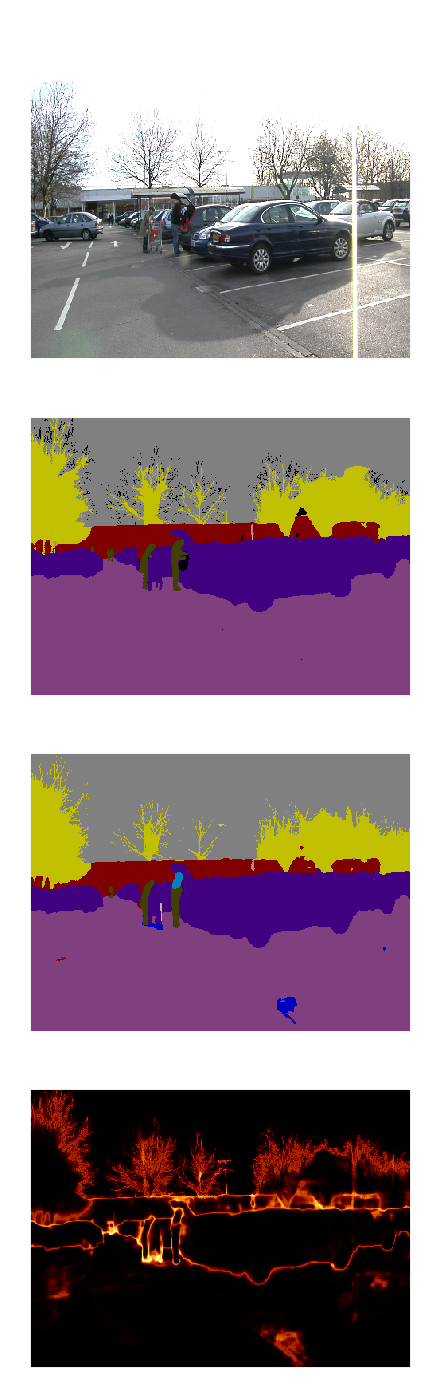

In [13]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0], epistemic=s[0], order=['X', 'y', 'y_pred', 'epistemic'])

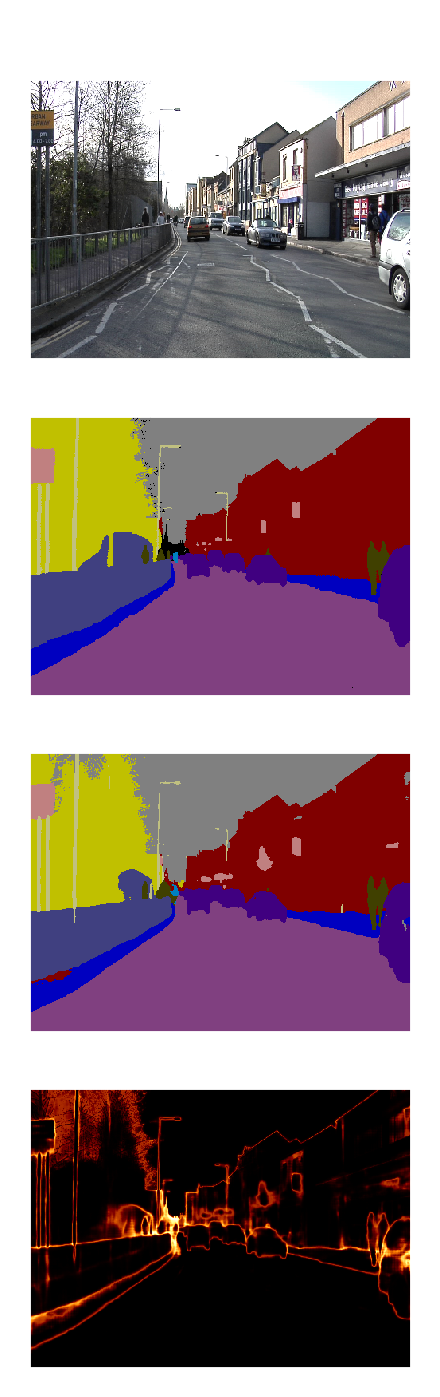

In [14]:
camvid.plot(X=X[1], y=y[1], y_pred=p[1], epistemic=s[1], order=['X', 'y', 'y_pred', 'epistemic'])

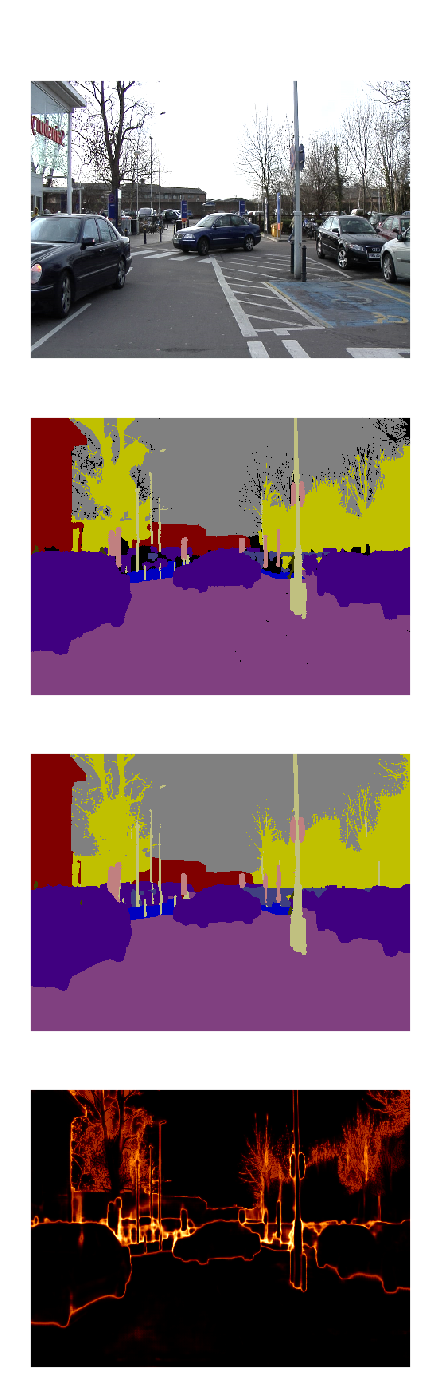

In [15]:
camvid.plot(X=X[2], y=y[2], y_pred=p[2], epistemic=s[2], order=['X', 'y', 'y_pred', 'epistemic'])

### Validation

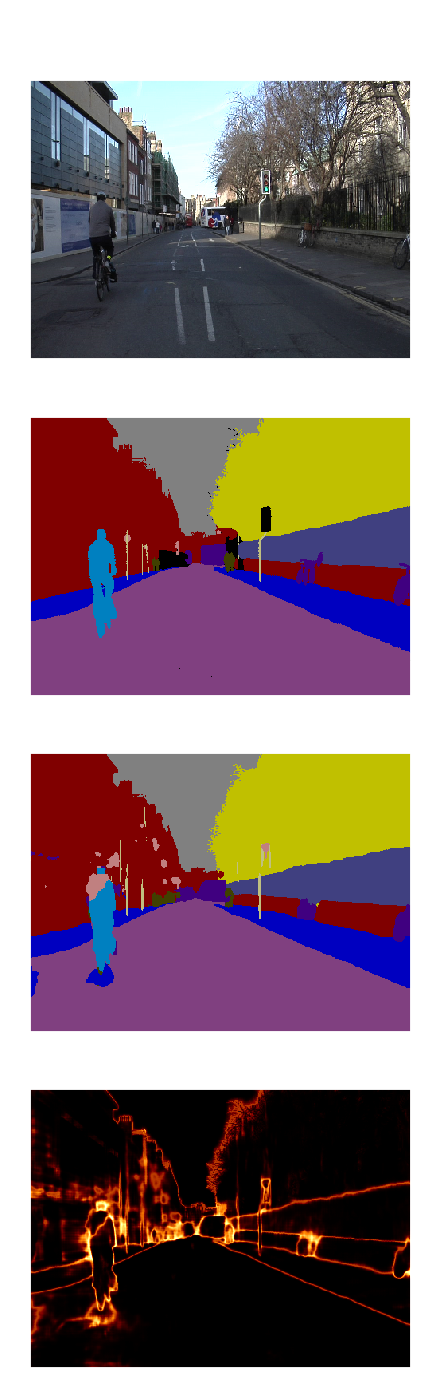

In [16]:
X, y, p, s = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], epistemic=s[0], order=['X', 'y', 'y_pred', 'epistemic'])

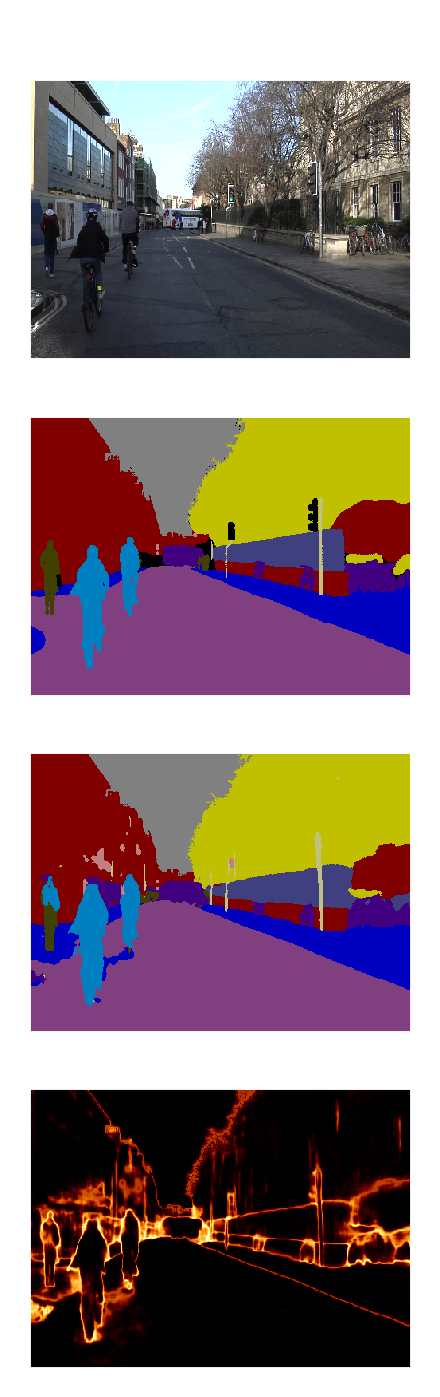

In [17]:
X, y, p, s = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], epistemic=s[0], order=['X', 'y', 'y_pred', 'epistemic'])

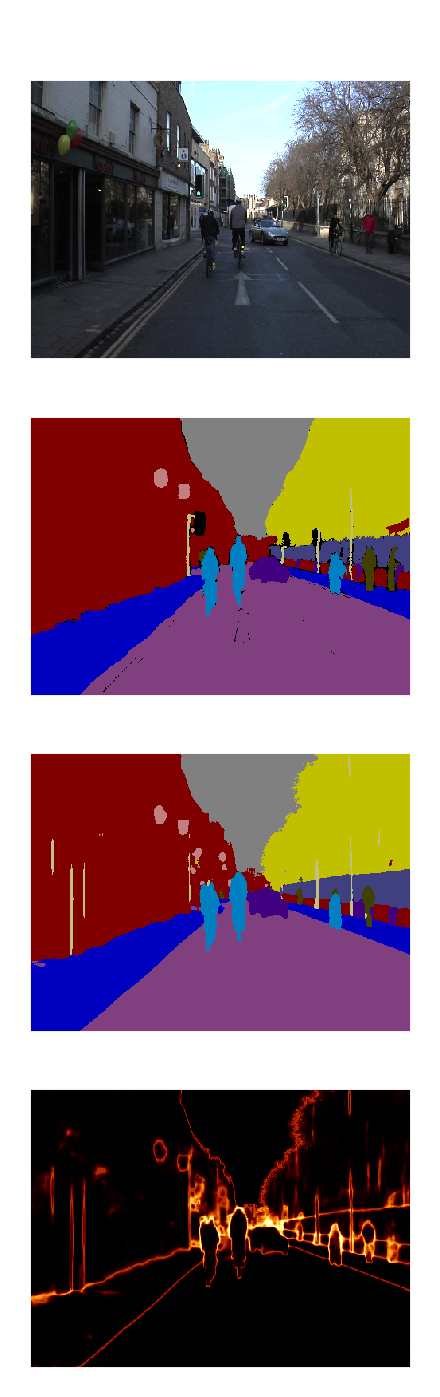

In [18]:
X, y, p, s = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], epistemic=s[0], order=['X', 'y', 'y_pred', 'epistemic'])

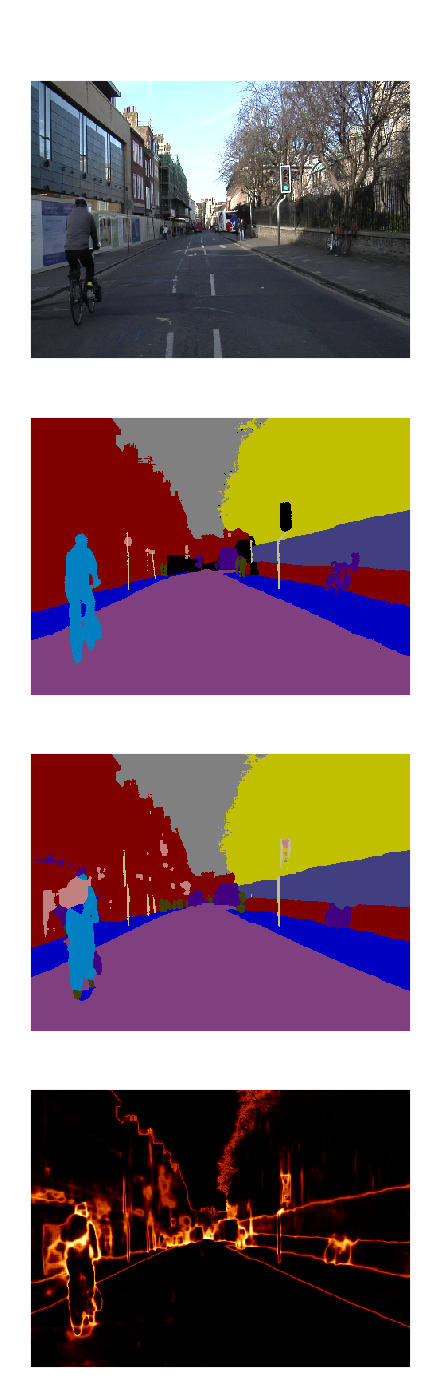

In [19]:
X, y, p, s = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], epistemic=s[0], order=['X', 'y', 'y_pred', 'epistemic'])

### Test

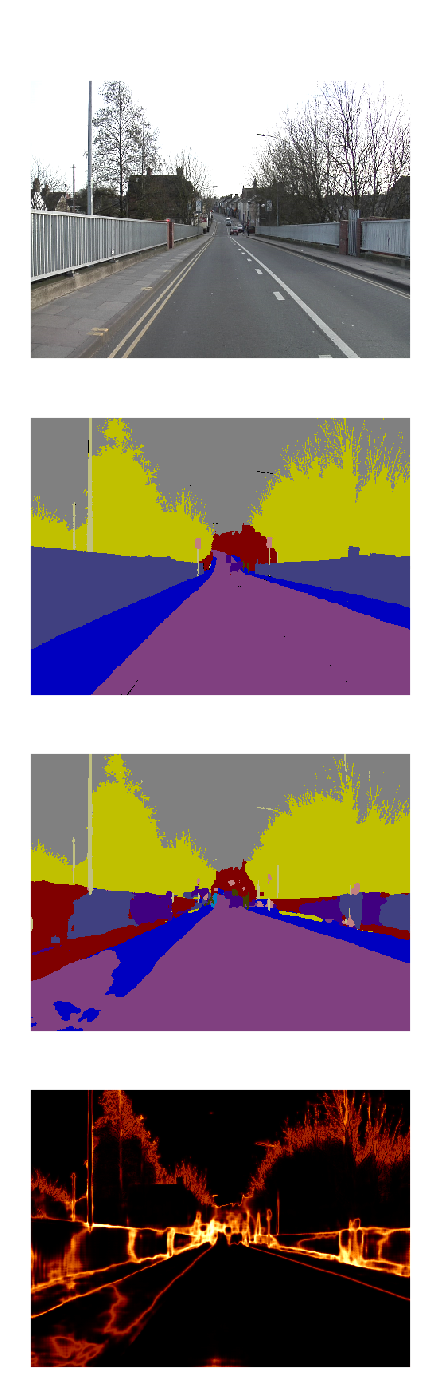

In [20]:
X, y, p, s = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], epistemic=s[0], order=['X', 'y', 'y_pred', 'epistemic'])

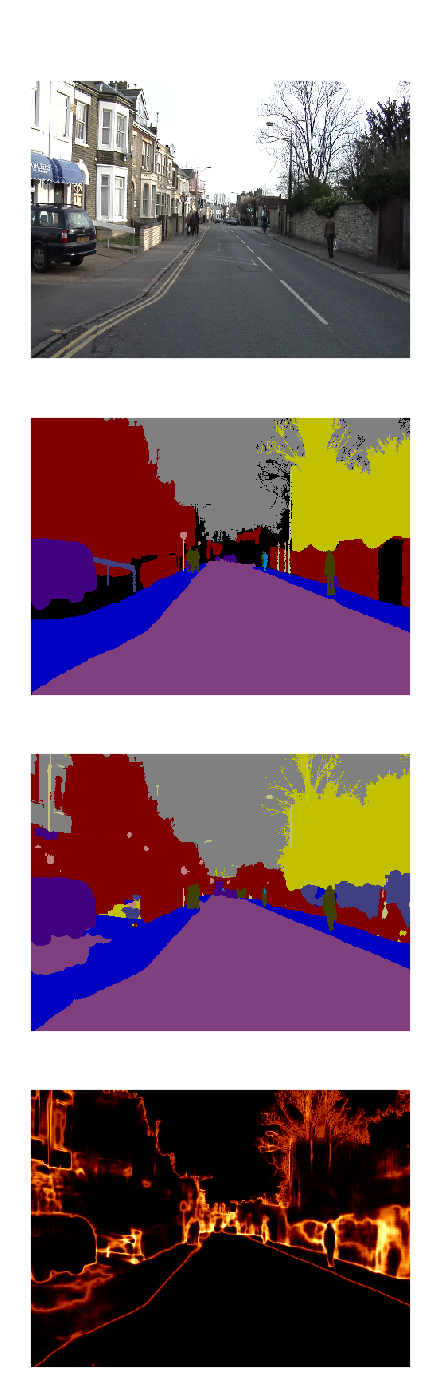

In [21]:
X, y, p, s = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], epistemic=s[0], order=['X', 'y', 'y_pred', 'epistemic'])

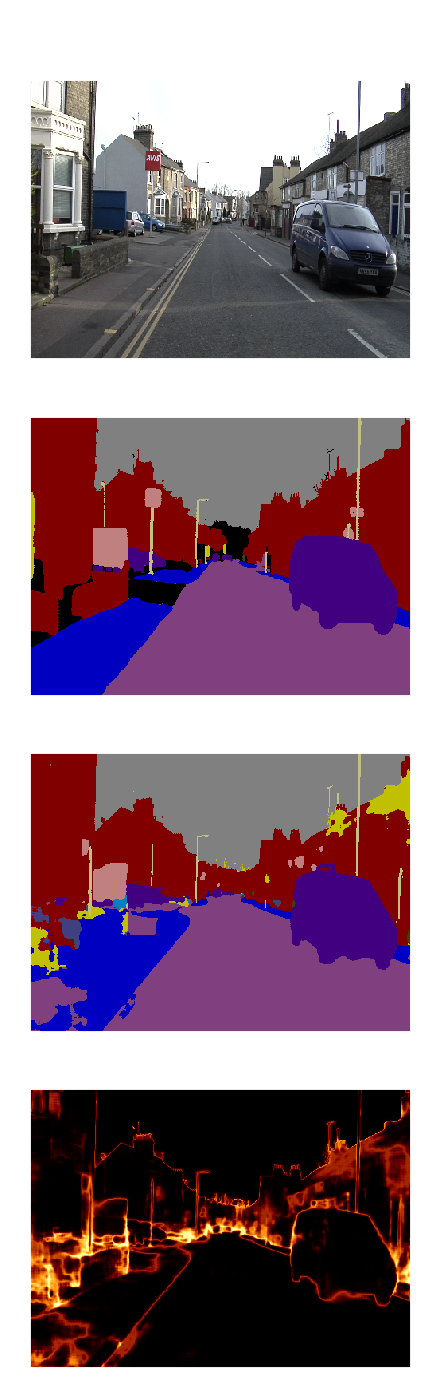

In [22]:
X, y, p, s = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], epistemic=s[0], order=['X', 'y', 'y_pred', 'epistemic'])

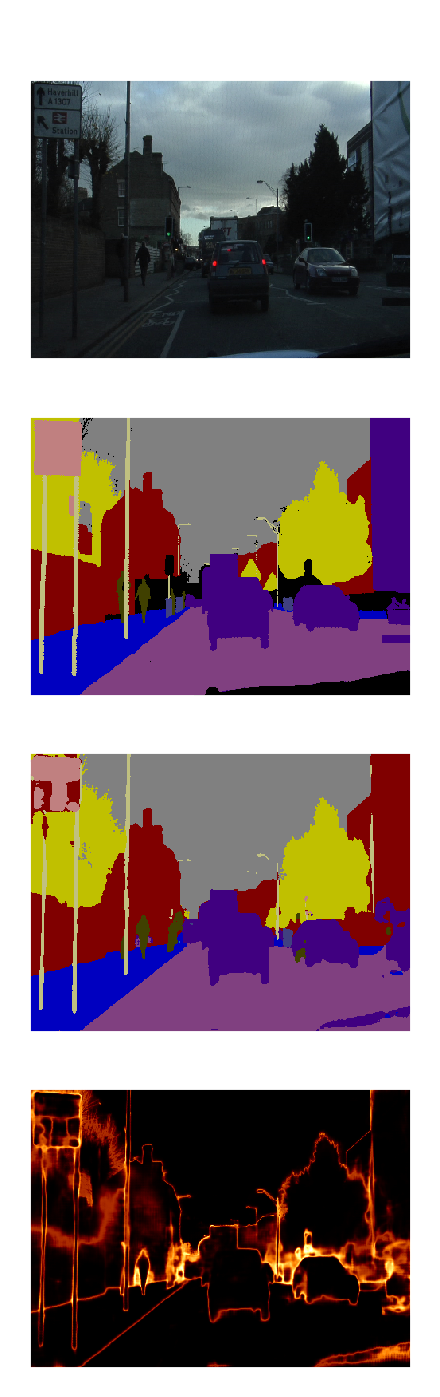

In [23]:
X, y, p, s = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], epistemic=s[0], order=['X', 'y', 'y_pred', 'epistemic'])